In [ ]:
%pip install aequitas

In [ ]:
%pip install optuna

In [ ]:
# import libraries
import copy
import glob
import os
import lightgbm as lgbm  # Tested ML method
import numpy as np       # Random number generation
import seaborn as sns    # Plotting library
import pandas as pd      # Read/write data
import yaml              # Read hyperparameter space configuration
import xgboost           # Tested ML method
from aequitas.group import Group                # Fairness metrics
from matplotlib import pyplot as plt            # Plotting method
from sklearn.preprocessing import LabelEncoder  # Categorical encoding for LGBM models
from sklearn import metrics                     # ROC metrics
from sklearn.ensemble import RandomForestClassifier
import joblib

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/ECE697/Project/random_search.py .

In [ ]:
from random_search import RandomValueTrial, suggest_callable_hyperparams  # Random search wrapper methods

In [ ]:
project_dir = "/content/drive/My Drive/Colab Notebooks/ECE697/Project/"

# V1 dataset augmentation



In [ ]:
# Previous 3 synthetic datasets couldn't satisfy expected augmented number of candidates
# Take best performing sample from additional synthetic datasets

synthetic_other_df = pd.read_csv(os.path.join(project_dir, "CTGAN Data/001/synthetic-dataset-001.csv"), index_col=0)

synthetic_other_df = synthetic_other_df.drop(columns=["Unnamed: 0"])

In [ ]:
# read in synthetic data
synthetic_df = pd.read_csv(os.path.join(project_dir, "Synthetic Data/synthetic-dataset-merged.csv"))

# read in dataset to mitigate
variant1_df = pd.read_csv(os.path.join(project_dir, "VariantI.csv"))

In [ ]:
# Checking number of columns in datasets

print(len(list(variant1_df)))

32


In [ ]:
synthetic_df = pd.concat([synthetic_df, synthetic_other_df])

In [ ]:
month_frequency =  variant1_df["month"].value_counts(normalize=True).to_dict()
month_fraud_prev = variant1_df.groupby("month")["fraud_bool"].mean().to_dict()

In [ ]:
print("Percent of total samples from each month:")
month_frequency

Percent of total samples from each month:


{3: 0.150938,
 2: 0.136979,
 0: 0.13244,
 4: 0.127691,
 1: 0.12762,
 5: 0.119322,
 6: 0.108168,
 7: 0.096842}

In [ ]:
print("Frequency of fraud within each month:")
month_fraud_prev

Frequency of fraud within each month:


{0: 0.011325883418906675,
 1: 0.009387243378780755,
 2: 0.008745866154666044,
 3: 0.009222329698286715,
 4: 0.011371200789405674,
 5: 0.011825145404870854,
 6: 0.013405073589231566,
 7: 0.014745668201813262}

In [ ]:
len(synthetic_df[synthetic_df["customer_age"] >= 50])

823725

In [ ]:
sample_size = 5e5 + 0

expected_positives = {}
expected_negatives = {}

for month in month_fraud_prev.keys():
    expected_positives[month] = round(sample_size * month_frequency[month] * month_fraud_prev[month], ndigits=None)
    expected_negatives[month] = round(sample_size * month_frequency[month] * (1-month_fraud_prev[month]), ndigits=None)

In [ ]:
expected_positives

{0: 750, 1: 599, 2: 599, 3: 696, 4: 726, 5: 706, 6: 725, 7: 714}

In [ ]:
expected_negatives

{0: 65470,
 1: 63211,
 2: 67890,
 3: 74773,
 4: 63120,
 5: 58956,
 6: 53359,
 7: 47707}

In [ ]:
base_dfs = []

SEED = 42

num_months = len(synthetic_df["month"].unique())
seed_possible_values = list(range(500_000))
seed_list = np.random.choice(seed_possible_values, size=num_months, replace=False)

for month, seed in zip(synthetic_df["month"].unique(), seed_list):
    positive_pool = synthetic_df[(synthetic_df["month"]==month) & (synthetic_df["customer_age"] >= 50) & (synthetic_df["fraud_bool"]==1)]
    negative_pool = synthetic_df[(synthetic_df["month"]==month) & (synthetic_df["customer_age"] >= 50) & (synthetic_df["fraud_bool"]==0)]

    positive_sample = positive_pool.sample(expected_positives[month], random_state=seed)
    negative_sample = negative_pool.sample(expected_negatives[month], random_state=seed+SEED)

    base_dfs.extend([positive_sample, negative_sample])

In [ ]:
# Concatenate the filtered samples to obtain the final dataset.
base_df = pd.concat(base_dfs)

In [ ]:
# Now generating the biased samples.
# We will start by defining the protected groups.
synthetic_df["group"] = (synthetic_df["customer_age"] >= 50).map({True:"Minority", False: "Majority"})

In [ ]:
# Helper method to define the joint probability of each combination of
# group and label.

def calculate_probabilities(
    original_prevalence: float,
    prev_ratio: float,
    maj_pct: float,
):
    # Probability notation (p_maj = P(A=maj))
    p_maj = maj_pct
    p_min = 1 - p_maj

    # Calculate prevalence for each class
    prev_min = original_prevalence / (prev_ratio * p_maj + (1 - p_maj))
    prev_maj = prev_ratio * prev_min

    # Calculate joint and conditional probabilities of majority group
    p_maj_and_pos = prev_maj * p_maj
    p_maj_giv_pos: float = p_maj_and_pos / original_prevalence
    p_maj_and_neg = p_maj - p_maj_and_pos
    p_maj_giv_neg: float = p_maj_and_neg / (1 - original_prevalence)

    # Calculate joint and conditional probabilities of minority group
    p_min_and_pos = prev_min * p_min
    p_min_giv_pos: float = p_min_and_pos / original_prevalence
    p_min_and_neg = p_min - p_min_and_pos
    p_min_giv_neg: float = p_min_and_neg / (1 - original_prevalence)

    return p_min_and_pos, p_maj_and_pos, p_min_and_neg, p_maj_and_neg

In [ ]:
# Helper method to obtain a dataframe from given group, month and label.
def get_filtered_df(synthetic_df, group, month, label):
    return synthetic_df[
        (synthetic_df["month"]==month) &
        (synthetic_df["group"]==group) &
        (synthetic_df["fraud_bool"]==label)]


# Method to generate a biased sample controling group size or prevalence (fraud rate)
def group_prevalence_disparity(synthetic_df, original_sample_df, majority_size, fraud_rate_disparity):
    seed_list = np.random.choice(seed_possible_values, size=num_months, replace=False)

    bias_dfs = []

    # Allow for different majority sizes/fraud rates depending on the month of data.
    # This replicates a value if only one is passed.
    if isinstance(majority_size, float):
        majority_size=[majority_size]*original_sample_df["month"].unique().shape[0]
    if isinstance(fraud_rate_disparity, (int, float)):
        fraud_rate_disparity=[fraud_rate_disparity]*original_sample_df["month"].unique().shape[0]

    for month, seed, maj_size, fr_disp in zip(synthetic_df["month"].unique(), seed_list, majority_size, fraud_rate_disparity):
        month_prevalence = original_sample_df[original_sample_df["month"]==month]["fraud_bool"].mean()
        (
            p_min_and_pos,
            p_maj_and_pos,
            p_min_and_neg,
            p_maj_and_neg,
        ) = calculate_probabilities(month_prevalence, 1/fr_disp, maj_size)

        month_size = original_sample_df["month"].value_counts(normalize=True)[month]*sample_size

        # Calculate the needed amount of each combination of group/label to satisfy the disparities in month.
        num_minority_positive = round(month_size*p_min_and_pos, 0)
        num_minority_negative = round(month_size*p_min_and_neg, 0)
        num_majority_positive = round(month_size*p_maj_and_pos, 0)
        num_majority_negative = round(month_size*p_maj_and_neg, 0)

        # Sample the large sample with expected values.
        bias_dfs.extend(
        [
            get_filtered_df(synthetic_df, "Minority", month, 1).sample(int(num_minority_positive), random_state=seed),
            get_filtered_df(synthetic_df, "Minority", month, 0).sample(int(num_minority_negative), random_state=seed+SEED),
            get_filtered_df(synthetic_df, "Majority", month, 1).sample(int(num_majority_positive), random_state=seed+2*SEED),
            get_filtered_df(synthetic_df, "Majority", month, 0).sample(int(num_majority_negative), random_state=seed+3*SEED),
        ]
        )

    return pd.concat(bias_dfs)

In [ ]:
majority_size = 0.2
fraud_rate_disparity = 1

augment_df = group_prevalence_disparity(synthetic_df, variant1_df, majority_size, fraud_rate_disparity)

In [ ]:
len(augment_df[augment_df["customer_age"] >= 50])

399999

In [ ]:
len(list(augment_df))

In [ ]:
# Remember to drop "group" column from augment_df

augment_df = augment_df.drop(columns=["group"])

In [ ]:
augmented_df = pd.concat([variant1_df, augment_df])
# write merged dataset to csv
augmented_df.to_csv(os.path.join(project_dir, "VariantI_augmented.csv"), index=False, encoding='utf-8')

In [ ]:
len(augmented_df)

1499999

In [ ]:
len(augmented_df[augmented_df["customer_age"] >= 50])

510698

# New experiments with the augmented Type I dataset

In [ ]:
v1_augmented_df = pd.read_csv(os.path.join(project_dir, "VariantI_augmented.csv"))

In [ ]:
len(list(v1_augmented_df))

32

In [ ]:
# Define the label field and categorical columns.
label = "fraud_bool"

categorical_features = [
    "payment_type",
    "employment_status",
    "housing_status",
    "source",
    "device_os",
]

In [ ]:
# Create the train and test sets. Shuffle data with `sample` method.
# The split was done by month. The first 6 months as the train, the last 2 months as test.
train_df = v1_augmented_df[v1_augmented_df["month"]<6].sample(frac=1, replace=False)
test_df = v1_augmented_df[v1_augmented_df["month"]>=6].sample(frac=1, replace=False)

In [ ]:
# Encode the categorical variables in the datasets to integers.
# This is expected by LGBM (or columns with the `categorical` data type).

for feat in categorical_features:
    encoder = LabelEncoder()
    encoder.fit(train_df[feat])  # Fit an encoder to the train set.
    train_df[feat] = encoder.transform(train_df[feat])  # Transform train set.
    test_df[feat] = encoder.transform(test_df[feat])    # Transform test set.

In [ ]:
# Helper method to obtain the metric values for a given model.
def get_results(results, metric):
    values = []
    for val in results[metric]:
        values.append(val)
    return values

# LightGBM

In [ ]:
# Load 100 saved LGBM models
lgbm_fnames = []
for name in glob.glob(os.path.join(project_dir, "Models/LGBM/TypeI_*")):
    lgbm_fnames.append(name)

runs = []

# Run on augmented df
for fname in lgbm_fnames:
    model = joblib.load(fname)
    #X_train = train_df.drop(columns=["fraud_bool"])
    #y_train = train_df["fraud_bool"]
    X_test = test_df.drop(columns=["fraud_bool"])
    y_test = test_df["fraud_bool"]

    # Obtain predictions in test data.
    predictions = model.predict_proba(X_test)[:, 1]

    # Obtain ROC curve for the predictions.
    fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
    # Obtain threshold and recall. We select 5% FPR as threshold.
    threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
    recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

    # Binarize predictions for Aequitas.
    preds_binary = (predictions > threshold).astype(int)

    # Create a dataframe with protected group column, predictions and labels.
    # Here, we select age >= 50 as threshold.
    aequitas_df = pd.DataFrame(
        {
            "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
            "score": preds_binary,
            "label_value": y_test.values

        }
    )

    #print(aequitas_df)
    # Obtain FPR results for different groups.
    g = Group()
    aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

    # Store the results for the trained model
    results = {}
    results["recall"] = recall
    results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
    results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
    results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
    results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

    # Store the results in the runs variable
    #prev_runs = runs.get(dataset_name, [])
    runs.append(results)

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=44, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=44
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM in

In [ ]:
# Helper method to obtain the metric values for a given model.
def get_results(results, metric):
    values = []
    for val in results[metric]:
        values.append(val)
    return values

In [ ]:
# Graph results of recall vs FPR ratio
rs_results = pd.DataFrame(runs)
plot_results = {"Recall": [], "FPR Ratio": []}
plot_results["Recall"] += get_results(rs_results, "recall")
# Obtain the FPR if both groups.
for fpr_younger, fpr_older in zip(get_results(rs_results, "fpr Younger"), get_results(rs_results, "fpr Older")):
    # Calculate FPR ratio as lower fpr / higher fpr
    if fpr_younger > fpr_older:
        plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
    else:
        plot_results["FPR Ratio"] += [fpr_younger/fpr_older]

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

plot_results.to_csv(os.path.join(project_dir, "Mitigated Variants/V1/lgbm_plot_results.csv"))

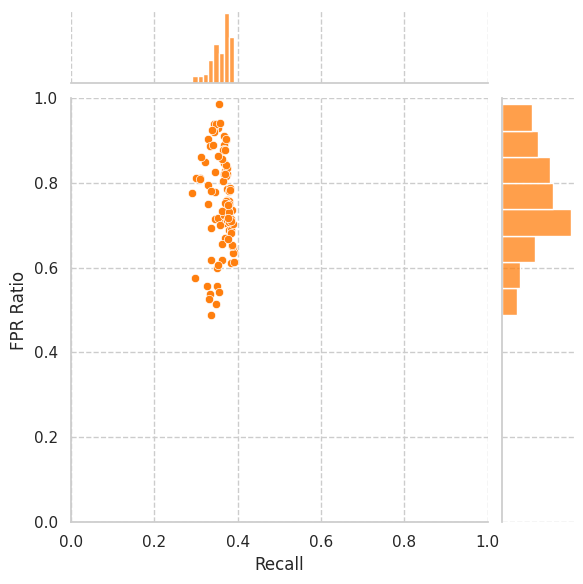

In [ ]:
# Create a plot with the full results of the random search algorithm.
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", color="tab:orange")
plt.ylim((0,1));
plt.xlim((0,1));

In [ ]:
# Read saved plot_results.csv for LGBM from original experiment

lgbm_results = pd.read_csv(os.path.join(project_dir, "Models", "LGBM", "plot_results.csv"), index_col=0)

In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets

avg_recall_old = lgbm_results[lgbm_results["Variant"] == "TypeI"]["Recall"].mean()
avg_fpr_ratio_old = lgbm_results[lgbm_results["Variant"] == "TypeI"]["FPR Ratio"].mean()

avg_recall_new = plot_results["Recall"].mean()
avg_fpr_ratio_new = plot_results["FPR Ratio"].mean()

In [ ]:
print(f"Initial V1 dataset had mean recall of {round(avg_recall_old, 3)} and mean FPR ratio of {round(avg_fpr_ratio_old, 3)}\n")
print(f"Augmented V1 dataset had mean recall of {round(avg_recall_new, 3)} and mean FPR ratio of {round(avg_fpr_ratio_new, 3)}")

Initial V1 dataset had mean recall of 0.494 and mean FPR ratio of 0.771

Augmented V1 dataset had mean recall of 0.36 and mean FPR ratio of 0.759


In [ ]:
# Compare average FPR Ratio and Recall model performance between intial and augmented datasets for top-5 models
top_n = 5
sum_recall, sum_fpr_ratio = 0, 0


type_1_top_5_idx = lgbm_results[lgbm_results['Variant'] == 'TypeI'].sort_values('Recall', ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += lgbm_results.iloc[type_1_top_5_idx[i]]["Recall"]
  sum_fpr_ratio += lgbm_results.iloc[type_1_top_5_idx[i]]["FPR Ratio"]

avg_top_5_recall_old = sum_recall / top_n
avg_top_5_fpr_ratio_old = sum_fpr_ratio / top_n


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values('Recall', ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

In [ ]:
print(f"Top 5 models of initial V1 dataset had mean recall of {round(avg_top_5_recall_old, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_old, 3)}\n")
print(f"Top 5 models of augmented V1 dataset had mean recall of {round(avg_top_5_recall_new, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")

Top 5 models of initial V1 dataset had mean recall of 0.533 and mean FPR ratio of 0.772

Top 5 models of augmented V1 dataset had mean recall of 0.39 and mean FPR ratio of 0.647


In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets for top-5 models
top_n = 5
sum_recall, sum_fpr_ratio = 0, 0


type_1_top_5_idx = lgbm_results[lgbm_results['Variant'] == 'TypeI'].sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += lgbm_results.iloc[type_1_top_5_idx[i]]["Recall"]
  sum_fpr_ratio += lgbm_results.iloc[type_1_top_5_idx[i]]["FPR Ratio"]

avg_top_5_recall_old = sum_recall / top_n
avg_top_5_fpr_ratio_old = sum_fpr_ratio / top_n


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

In [ ]:
print(f"Top 5 fairness models of initial V1 dataset had mean recall of {round(avg_top_5_recall_old, 3)} " \
        f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_old, 3)}\n")

print(f"Top 5 fairness models of augmented V1 dataset had mean recall of {round(avg_top_5_recall_new, 3)} " \
        f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")

Top 5 fairness models of initial V1 dataset had mean recall of 0.439 and mean FPR ratio of 0.973

Top 5 fairness models of augmented V1 dataset had mean recall of 0.35 and mean FPR ratio of 0.948


### Run 50 new random models to determine if dataset bias mitigation has led to fairer dataset for future experimentation

In [ ]:
# Read .yml for LGBM hyperparameter space
with open("/content/drive/MyDrive/Colab Notebooks/ECE697/Project/lightgbm_hyperparameter_space_original.yaml", "r") as file:
    hyperparam_space = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
# Run 50 new LGBM models
# 2h

# Define number of trials in Random search.
n_trials=50
# Random state for sampling seeds.
np.random.seed(42)
# Seeds for the random search sampling algorithm.
seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

runs = []

for trial in range(n_trials):
    seed = seeds[trial]
    trial = RandomValueTrial(seed=seed)
    # Hyperparameters for the random search trial.
    test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
    del test_hyperparams["classpath"] # Remove unnecessary key in hyperparameters.

    model = lgbm.LGBMClassifier(n_jobs=10, **test_hyperparams)

    X_train = train_df.drop(columns=["fraud_bool"])
    y_train = train_df["fraud_bool"]
    X_test = test_df.drop(columns=["fraud_bool"])
    y_test = test_df["fraud_bool"]

    # Fit new model
    model.fit(X_train, y_train, categorical_feature=categorical_features)

    # Obtain predictions in test data.
    predictions = model.predict_proba(X_test)[:, 1]

    # Obtain ROC curve for the predictions.
    fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
    # Obtain threshold and recall. We select 5% FPR as threshold.
    threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
    recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

    # Binarize predictions for Aequitas.
    preds_binary = (predictions > threshold).astype(int)

    # Create a dataframe with protected group column, predictions and labels.
    # Here, we select age >= 50 as threshold.
    aequitas_df = pd.DataFrame(
        {
            "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
            "score": preds_binary,
            "label_value": y_test.values

        }
    )

    #print(aequitas_df)
    # Obtain FPR results for different groups.
    g = Group()
    aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

    # Store the results for the trained model
    results = {}
    results["recall"] = recall
    results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
    results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
    results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
    results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

    # Store the results in the runs variable
    #prev_runs = runs.get(dataset_name, [])
    runs.append(results)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# Graph results of recall vs FPR ratio
rs_results = pd.DataFrame(runs)
plot_results = {"Recall": [], "FPR Ratio": []}
plot_results["Recall"] += get_results(rs_results, "recall")
# Obtain the FPR if both groups.
for fpr_younger, fpr_older in zip(get_results(rs_results, "fpr Younger"), get_results(rs_results, "fpr Older")):
    # Calculate FPR ratio as lower fpr / higher fpr
    if fpr_younger > fpr_older:
        plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
    else:
        plot_results["FPR Ratio"] += [fpr_younger/fpr_older]

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

plot_results.to_csv(os.path.join(project_dir, "Mitigated Variants/V1/lgbm_plot_results_new.csv"))

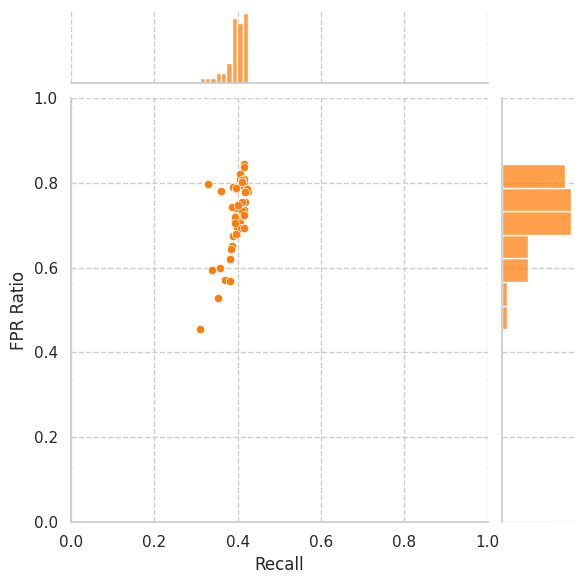

In [ ]:
# Graph results of recall vs FPR ratio
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", color="tab:orange")
plt.ylim((0,1));
plt.xlim((0,1));

In [ ]:
# Find average recall, fpr ratio for newly trained models
top_n = 5
print("\nLGBM:\n\n")

avg_recall_new = plot_results["Recall"].mean()
avg_fpr_ratio_new = plot_results["FPR Ratio"].mean()

print(f"Newly trained LGBM models on augmented V1 dataset had mean recall of {round(avg_recall_new, 3)} and mean FPR ratio of {round(avg_fpr_ratio_new, 3)}")

sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("Recall", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

print(f"Top 5 newly trained models of augmented V1 dataset had mean recall of {round(avg_top_5_recall_new, 3)} " \
        f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

print(f"Top 5 newly trained fairness models of augmented V1 dataset had mean recall of {round(avg_top_5_recall_new, 3)} " \
           f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")

Newly trained LGBM models on augmented V1 dataset had mean recall of 0.395 and mean FPR ratio of 0.72
Top 5 newly trained models of augmented V1 dataset had mean recall of 0.419 and mean FPR ratio of 0.78
Top 5 newly trained fairness models of augmented V1 dataset had mean recall of 0.411 and mean FPR ratio of 0.824


# XGBoost

In [ ]:
# Load 100 saved XGBoost models
xgb_fnames = []
for name in glob.glob(os.path.join(project_dir, "Models/XGB/TypeI_*")):
    xgb_fnames.append(name)

runs = []

# Run on augmented df
for fname in xgb_fnames:
    model = joblib.load(fname)
    #X_train = train_df.drop(columns=["fraud_bool"])
    #y_train = train_df["fraud_bool"]
    X_test = test_df.drop(columns=["fraud_bool"])
    y_test = test_df["fraud_bool"]

    # Obtain predictions in test data.
    predictions = model.predict_proba(X_test)[:, 1]

    # Obtain ROC curve for the predictions.
    fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
    # Obtain threshold and recall. We select 5% FPR as threshold.
    threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
    recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

    # Binarize predictions for Aequitas.
    preds_binary = (predictions > threshold).astype(int)

    # Create a dataframe with protected group column, predictions and labels.
    # Here, we select age >= 50 as threshold.
    aequitas_df = pd.DataFrame(
        {
            "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
            "score": preds_binary,
            "label_value": y_test.values

        }
    )

    #print(aequitas_df)
    # Obtain FPR results for different groups.
    g = Group()
    aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

    # Store the results for the trained model
    results = {}
    results["recall"] = recall
    results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
    results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
    results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
    results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

    # Store the results in the runs variable
    #prev_runs = runs.get(dataset_name, [])
    runs.append(results)

In [ ]:
# Helper method to obtain the metric values for a given model.
def get_results(results, metric):
    values = []
    for val in results[metric]:
        values.append(val)
    return values

In [ ]:
# Graph results of recall vs FPR ratio
rs_results = pd.DataFrame(runs)
plot_results = {"Recall": [], "FPR Ratio": []}
plot_results["Recall"] += get_results(rs_results, "recall")
# Obtain the FPR if both groups.
for fpr_younger, fpr_older in zip(get_results(rs_results, "fpr Younger"), get_results(rs_results, "fpr Older")):
    # Calculate FPR ratio as lower fpr / higher fpr
    if fpr_younger > fpr_older:
        plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
    else:
        plot_results["FPR Ratio"] += [fpr_younger/fpr_older]

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

plot_results.to_csv(os.path.join(project_dir, "Mitigated Variants/V1/xgb_plot_results.csv"))

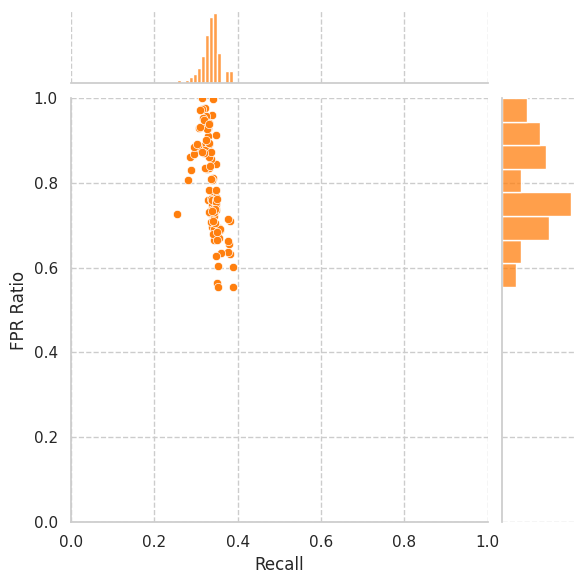

In [ ]:
# Figure out if this can be overlaid on top of below graph

# Create a plot with the full results of the random search algorithm.
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", color="tab:orange")
plt.ylim((0,1));
plt.xlim((0,1));

In [ ]:
# Read saved plot_results.csv for XGBoost from original experiment

xgb_results = pd.read_csv(os.path.join(project_dir, "Models", "XGB", "plot_results.csv"), index_col=0)

In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets

avg_recall_old = xgb_results[xgb_results["Variant"] == "TypeI"]["Recall"].mean()
avg_fpr_ratio_old = xgb_results[xgb_results["Variant"] == "TypeI"]["FPR Ratio"].mean()

avg_recall_new = plot_results["Recall"].mean()
avg_fpr_ratio_new = plot_results["FPR Ratio"].mean()

In [ ]:
print(f"Initial V1 dataset had mean recall of {round(avg_recall_old, 3)} and mean FPR ratio of {round(avg_fpr_ratio_old, 3)}\n")
print(f"Augmented V1 dataset had mean recall of {round(avg_recall_new, 3)} and mean FPR ratio of {round(avg_fpr_ratio_new, 3)}")

Initial V1 dataset had mean recall of 0.456 and mean FPR ratio of 0.713

Augmented V1 dataset had mean recall of 0.336 and mean FPR ratio of 0.787


In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets for top-5 models
top_n = 5
sum_recall, sum_fpr_ratio = 0, 0


type_1_top_5_idx = xgb_results[xgb_results['Variant'] == 'TypeI'].sort_values('Recall', ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += xgb_results.iloc[type_1_top_5_idx[i]]["Recall"]
  sum_fpr_ratio += xgb_results.iloc[type_1_top_5_idx[i]]["FPR Ratio"]

avg_top_5_recall_old = sum_recall / top_n
avg_top_5_fpr_ratio_old = sum_fpr_ratio / top_n


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values('Recall', ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

In [ ]:
print(f"Top 5 models of initial V1 dataset had mean recall of {round(avg_top_5_recall_old, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_old, 3)}\n")
print(f"Top 5 models of augmented V1 dataset had mean recall of {round(avg_top_5_recall_new, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")

Top-5 models of initial V1 dataset had mean recall of 0.518 and mean FPR ratio of 0.71

Top 5 models of augmented V1 dataset had mean recall of 0.384 and mean FPR ratio of 0.631


In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets for top-5 models
top_n = 5
sum_recall, sum_fpr_ratio = 0, 0


type_1_top_5_idx = xgb_results[xgb_results['Variant'] == 'TypeI'].sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += xgb_results.iloc[type_1_top_5_idx[i]]["Recall"]
  sum_fpr_ratio += xgb_results.iloc[type_1_top_5_idx[i]]["FPR Ratio"]

avg_top_5_recall_old = sum_recall / top_n
avg_top_5_fpr_ratio_old = sum_fpr_ratio / top_n


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

In [ ]:
print(f"Top 5 fairness models of initial V1 dataset had mean recall of {round(avg_top_5_recall_old, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_old, 3)}\n")
print(f"Top 5 fairness models of augmented V1 dataset had mean recall of {round(avg_top_5_recall_new, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")

Top 5 fairness models of initial V1 dataset had mean recall of 0.471 and mean FPR ratio of 0.922

Top 5 fairness models of augmented V1 dataset had mean recall of 0.32 and mean FPR ratio of 0.983


### Run 50 new random models to determine if dataset bias mitigation has led to fairer dataset for future experimentation

In [ ]:
# Read .yml for XGB hyperparameter space
with open("/content/drive/MyDrive/Colab Notebooks/ECE697/Project/xgboost_hyperspace_parameter.yaml", "r") as file:
    hyperparam_space = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
# Run 50 new XGB models
# 18m

# Define number of trials in Random search.
n_trials=50
# Random state for sampling seeds.
np.random.seed(42)
# Seeds for the random search sampling algorithm.
seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

runs = []

for trial in range(n_trials):
    seed = seeds[trial]
    trial = RandomValueTrial(seed=seed)
    # Hyperparameters for the random search trial.
    test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
    del test_hyperparams["classpath"] # Remove unnecessary key in hyperparameters.

    model = xgboost.XGBClassifier(n_jobs=10, **test_hyperparams, enable_categorical=True)  # enable_categorical=True, # may need to add this

    X_train = train_df.drop(columns=["fraud_bool"])
    y_train = train_df["fraud_bool"]
    X_test = test_df.drop(columns=["fraud_bool"])
    y_test = test_df["fraud_bool"]

    # Fit new model
    model.fit(X_train, y_train)

    # Obtain predictions in test data.
    predictions = model.predict_proba(X_test)[:, 1]

    # Obtain ROC curve for the predictions.
    fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
    # Obtain threshold and recall. We select 5% FPR as threshold.
    threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
    recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

    # Binarize predictions for Aequitas.
    preds_binary = (predictions > threshold).astype(int)

    # Create a dataframe with protected group column, predictions and labels.
    # Here, we select age >= 50 as threshold.
    aequitas_df = pd.DataFrame(
        {
            "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
            "score": preds_binary,
            "label_value": y_test.values

        }
    )

    #print(aequitas_df)
    # Obtain FPR results for different groups.
    g = Group()
    aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

    # Store the results for the trained model
    results = {}
    results["recall"] = recall
    results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
    results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
    results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
    results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

    # Store the results in the runs variable
    #prev_runs = runs.get(dataset_name, [])
    runs.append(results)

In [ ]:
rs_results = pd.DataFrame(runs)
plot_results = {"Recall": [], "FPR Ratio": []}
plot_results["Recall"] += get_results(rs_results, "recall")
# Obtain the FPR if both groups.
for fpr_younger, fpr_older in zip(get_results(rs_results, "fpr Younger"), get_results(rs_results, "fpr Older")):
    # Calculate FPR ratio as lower fpr / higher fpr
    if fpr_younger > fpr_older:
        plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
    else:
        plot_results["FPR Ratio"] += [fpr_younger/fpr_older]

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

plot_results.to_csv(os.path.join(project_dir, "Mitigated Variants/V1/xgb_plot_results_new.csv"))

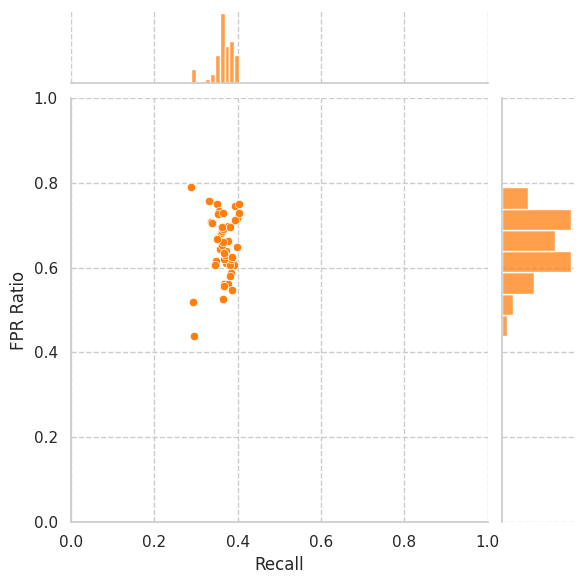

In [ ]:
# Graph results of recall vs FPR ratio

sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", color="tab:orange")
plt.ylim((0,1));
plt.xlim((0,1));

In [ ]:
# Find average recall, fpr ratio for newly trained models
top_n = 5
print("\nXGBoost:\n\n")

avg_recall_new = plot_results["Recall"].mean()
avg_fpr_ratio_new = plot_results["FPR Ratio"].mean()

print(f"Newly trained XGB models on augmented V1 dataset had mean recall of {round(avg_recall_new, 3)} and mean FPR ratio of {round(avg_fpr_ratio_new, 3)}")

sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("Recall", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

print(f"Top 5 newly trained models of augmented V1 dataset had mean recall of {round(avg_top_5_recall_new, 3)} " \
        f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

print(f"Top 5 newly trained fairness models of augmented V1 dataset had mean recall of {round(avg_top_5_recall_new, 3)} " \
           f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")


XGBoost:


Newly trained XGB models on augmented V1 dataset had mean recall of 0.366 and mean FPR ratio of 0.652
Top 5 newly trained models of augmented V1 dataset had mean recall of 0.399 and mean FPR ratio of 0.718
Top 5 newly trained fairness models of augmented V1 dataset had mean recall of 0.353 and mean FPR ratio of 0.758


## Random Forest ##

In [ ]:
# Load 100 saved RF models

rf_fnames = []
for name in glob.glob(os.path.join(project_dir, "Models/RF/TypeI_*")):
    rf_fnames.append(name)

runs = []

# Run on augmented df
for fname in rf_fnames:
    model = joblib.load(fname)
    #X_train = train_df.drop(columns=["fraud_bool"])
    #y_train = train_df["fraud_bool"]
    X_test = test_df.drop(columns=["fraud_bool"])
    y_test = test_df["fraud_bool"]

    # Obtain predictions in test data.
    predictions = model.predict_proba(X_test)[:, 1]

    # Obtain ROC curve for the predictions.
    fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
    # Obtain threshold and recall. We select 5% FPR as threshold.
    threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
    recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

    # Binarize predictions for Aequitas.
    preds_binary = (predictions > threshold).astype(int)

    # Create a dataframe with protected group column, predictions and labels.
    # Here, we select age >= 50 as threshold.
    aequitas_df = pd.DataFrame(
        {
            "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
            "score": preds_binary,
            "label_value": y_test.values

        }
    )

    #print(aequitas_df)
    # Obtain FPR results for different groups.
    g = Group()
    aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

    # Store the results for the trained model
    results = {}
    results["recall"] = recall
    results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
    results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
    results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
    results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

    # Store the results in the runs variable
    #prev_runs = runs.get(dataset_name, [])
    runs.append(results)

In [ ]:
# Helper method to obtain the metric values for a given model.
def get_results(results, metric):
    values = []
    for val in results[metric]:
        values.append(val)
    return values

In [ ]:
# Graph results of recall vs FPR ratio
rs_results = pd.DataFrame(runs)
plot_results = {"Recall": [], "FPR Ratio": []}
plot_results["Recall"] += get_results(rs_results, "recall")
# Obtain the FPR if both groups.
for fpr_younger, fpr_older in zip(get_results(rs_results, "fpr Younger"), get_results(rs_results, "fpr Older")):
    # Calculate FPR ratio as lower fpr / higher fpr
    if fpr_younger > fpr_older:
        plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
    else:
        plot_results["FPR Ratio"] += [fpr_younger/fpr_older]

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

plot_results.to_csv(os.path.join(project_dir, "Mitigated Variants/V1/rf_plot_results.csv"))

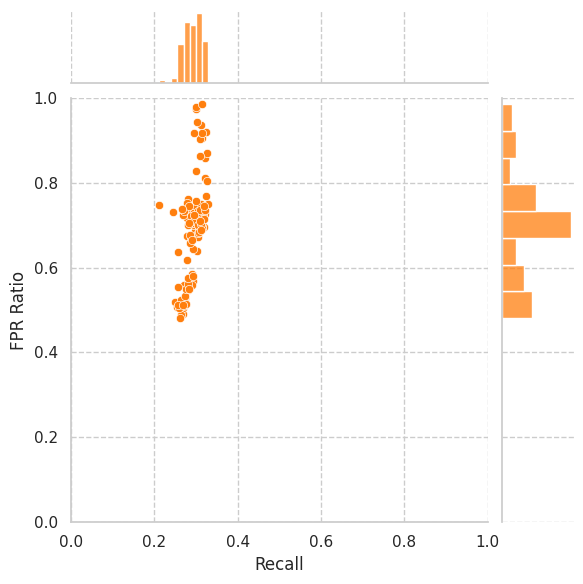

In [ ]:
# Figure out if this can be overlaid on top of below graph

# Create a plot with the full results of the random search algorithm.
sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", color="tab:orange")
plt.ylim((0,1));
plt.xlim((0,1));

In [ ]:
# Read saved plot_results.csv for Random Forest

rf_results = pd.read_csv(os.path.join(project_dir, "Models", "RF", "plot_results.csv"), index_col=0)

In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets

avg_recall_old = rf_results[rf_results["Variant"] == "TypeI"]["Recall"].mean()
avg_fpr_ratio_old = rf_results[rf_results["Variant"] == "TypeI"]["FPR Ratio"].mean()

avg_recall_new = plot_results["Recall"].mean()
avg_fpr_ratio_new = plot_results["FPR Ratio"].mean()

In [ ]:
print(f"Initial V1 dataset had mean recall of {round(avg_recall_old, 3)} and mean FPR ratio of {round(avg_fpr_ratio_old, 3)}\n")
print(f"Augmented V1 dataset had mean recall of {round(avg_recall_new, 3)} and mean FPR ratio of {round(avg_fpr_ratio_new, 3)}")

Initial V1 dataset had mean recall of 0.425 and mean FPR ratio of 0.541

Augmented V1 dataset had mean recall of 0.292 and mean FPR ratio of 0.694


In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets for top-5 models
top_n = 5
sum_recall, sum_fpr_ratio = 0, 0


type_1_top_5_idx = rf_results[rf_results['Variant'] == 'TypeI'].sort_values('Recall', ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += rf_results.iloc[type_1_top_5_idx[i]]["Recall"]
  sum_fpr_ratio += rf_results.iloc[type_1_top_5_idx[i]]["FPR Ratio"]

avg_top_5_recall_old = sum_recall / top_n
avg_top_5_fpr_ratio_old = sum_fpr_ratio / top_n


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values('Recall', ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

In [ ]:
print(f"Top 5 models of initial V1 dataset had mean recall of {round(avg_top_5_recall_old, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_old, 3)}\n")
print(f"Top 5 models of augmented V1 dataset had mean recall of {round(avg_top_5_recall_new, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")

Top 5 models of initial V1 dataset had mean recall of 0.466 and mean FPR ratio of 0.527

Top 5 models of augmented V1 dataset had mean recall of 0.326 and mean FPR ratio of 0.822


In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets for top-5 models
top_n = 5
sum_recall, sum_fpr_ratio = 0, 0


type_1_top_5_idx = rf_results[rf_results['Variant'] == 'TypeI'].sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += rf_results.iloc[type_1_top_5_idx[i]]["Recall"]
  sum_fpr_ratio += rf_results.iloc[type_1_top_5_idx[i]]["FPR Ratio"]

avg_top_5_recall_old = sum_recall / top_n
avg_top_5_fpr_ratio_old = sum_fpr_ratio / top_n


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

In [ ]:
print(f"Top 5 fairness models of initial V1 dataset had mean recall of {round(avg_top_5_recall_old, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_old, 3)}\n")
print(f"Top 5 fairness models of augmented V1 dataset had mean recall of {round(avg_top_5_recall_new, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")

Top 5 fairness models of initial V1 dataset had mean recall of 0.378 and mean FPR ratio of 0.645

Top 5 fairness models of augmented V1 dataset had mean recall of 0.305 and mean FPR ratio of 0.963


### Run 50 new random models to determine if dataset bias mitigation has led to fairer dataset for future experimentation

In [ ]:
# Read .yml for RF hyperparameter space

with open("/content/drive/MyDrive/Colab Notebooks/ECE697/Project/randomforest_hyperspace_parameter.yaml", "r") as file:
    hyperparam_space = yaml.load(file, Loader=yaml.FullLoader)

In [ ]:
# Run 50 new RF models
# 38m

# Define number of trials in Random search.
n_trials=50
# Random state for sampling seeds.
np.random.seed(42)
# Seeds for the random search sampling algorithm.
seeds = np.random.choice(list(range(1_000_000)), size=n_trials, replace=False)

runs = []

for trial in range(n_trials):
    seed = seeds[trial]
    trial = RandomValueTrial(seed=seed)
    # Hyperparameters for the random search trial.
    test_hyperparams = suggest_callable_hyperparams(trial, hyperparam_space)
    del test_hyperparams["classpath"] # Remove unnecessary key in hyperparameters.

    model = RandomForestClassifier(n_jobs=10, **test_hyperparams)

    X_train = train_df.drop(columns=["fraud_bool"])
    y_train = train_df["fraud_bool"]
    X_test = test_df.drop(columns=["fraud_bool"])
    y_test = test_df["fraud_bool"]

    # Fit new model
    model.fit(X_train, y_train)

    # Obtain predictions in test data.
    predictions = model.predict_proba(X_test)[:, 1]

    # Obtain ROC curve for the predictions.
    fprs, tprs, thresholds = metrics.roc_curve(y_test, predictions)
    # Obtain threshold and recall. We select 5% FPR as threshold.
    threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
    recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

    # Binarize predictions for Aequitas.
    preds_binary = (predictions > threshold).astype(int)

    # Create a dataframe with protected group column, predictions and labels.
    # Here, we select age >= 50 as threshold.
    aequitas_df = pd.DataFrame(
        {
            "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
            "score": preds_binary,
            "label_value": y_test.values

        }
    )

    #print(aequitas_df)
    # Obtain FPR results for different groups.
    g = Group()
    aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

    # Store the results for the trained model
    results = {}
    results["recall"] = recall
    results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
    results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
    results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
    results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

    # Store the results in the runs variable
    #prev_runs = runs.get(dataset_name, [])
    runs.append(results)

In [ ]:
rs_results = pd.DataFrame(runs)
plot_results = {"Recall": [], "FPR Ratio": []}
plot_results["Recall"] += get_results(rs_results, "recall")
# Obtain the FPR if both groups.
for fpr_younger, fpr_older in zip(get_results(rs_results, "fpr Younger"), get_results(rs_results, "fpr Older")):
    # Calculate FPR ratio as lower fpr / higher fpr
    if fpr_younger > fpr_older:
        plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
    else:
        plot_results["FPR Ratio"] += [fpr_younger/fpr_older]

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

plot_results.to_csv(os.path.join(project_dir, "Mitigated Variants/V1/rf_plot_results_new.csv"))

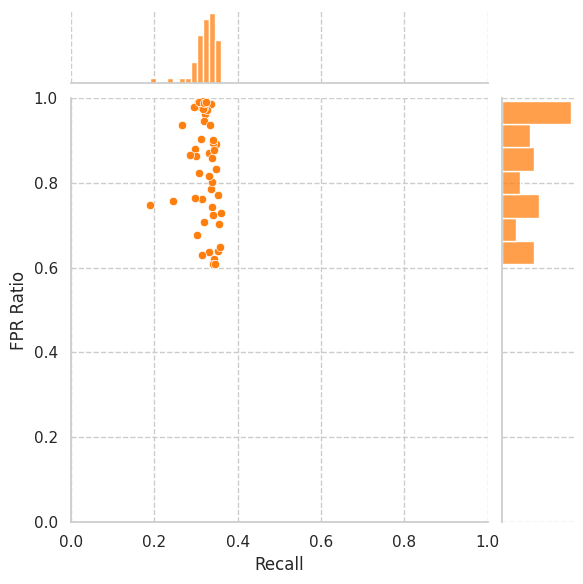

In [ ]:
# Graph results of recall vs FPR ratio

sns.set()
sns.set_style("whitegrid", {"grid.linestyle": "--"})

sns.jointplot(data=plot_results, x="Recall", y="FPR Ratio", color="tab:orange")
plt.ylim((0,1));
plt.xlim((0,1));

In [ ]:
# Find average recall, fpr ratio for newly trained models
top_n = 5
print("\nRandom Forest:\n\n")

avg_recall_new = plot_results["Recall"].mean()
avg_fpr_ratio_new = plot_results["FPR Ratio"].mean()

print(f"Newly trained XGB models on augmented V1 dataset had mean recall of {round(avg_recall_new, 3)} and mean FPR ratio of {round(avg_fpr_ratio_new, 3)}")

sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("Recall", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

print(f"Top 5 newly trained models of augmented V1 dataset had mean recall of {round(avg_top_5_recall_new, 3)} " \
        f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

print(f"Top 5 newly trained fairness models of augmented V1 dataset had mean recall of {round(avg_top_5_recall_new, 3)} " \
           f"and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")


Random Forest:


Newly trained XGB models on augmented V1 dataset had mean recall of 0.321 and mean FPR ratio of 0.838
Top 5 newly trained models of augmented V1 dataset had mean recall of 0.355 and mean FPR ratio of 0.698
Top 5 newly trained fairness models of augmented V1 dataset had mean recall of 0.313 and mean FPR ratio of 0.991


#ResNeXt

In [ ]:
import ast

In [ ]:
# define device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
def build_torch_dataset(df: pd.DataFrame, feature_columns):
    """ Create a torch tensor from the pandas dataframe according to the order of the features in feature_columns
    Cannot just use torch.tensor(df.values) because for variable length columns, it contains a list.
    Args:
        df (pandas.DataFrame): dataframe containing the features
        feature_columns (List)
    Returns:
        (torch.Tensor): pytorch tensor from df according to the order of feature_columns

    Credit to: https://medium.com/@ngiengkianyew/how-to-efficiently-work-with-thousands-of-features-from-pandas-to-pytorch-9e5c1e1d4329
    """
    tensors = []
    df = df.copy()
    feature_length_names = []
    if len(feature_columns) > 1:
        for feat in feature_columns:
            d_type = str(df[feat].dtype)
            if isinstance(d_type, str):
                torch_dtype = getattr(torch, d_type)
            tensor = torch.tensor(df[feat].values, dtype=torch_dtype)
            # have to convert tensor values to torch.float32
            tensor = tensor.type(torch.float32)
            tensors.append(tensor.reshape(-1,1))
    else:
        d_type = str(df.dtype)
        if isinstance(d_type, str):
            torch_dtype = getattr(torch, d_type)
        tensor = torch.tensor(df.values, dtype=torch_dtype)
        tensor = tensor.type(torch.float32)
        tensors.append(tensor.reshape(-1,1))

    return torch.concat(tensors, dim=1)

In [ ]:
# Create Pytorch Dataset
class FFDataset(Dataset):
    def __init__(self, df):
        # receive overall df
        # split into training data and labels
        data = df.drop(columns=["fraud_bool"])
        labels = df["fraud_bool"]

        self.torch_data = build_torch_dataset(data, list(data))
        self.torch_labels = build_torch_dataset(labels, ["fraud_bool"])

        # Create training and testing datasets
        #X_train = train_dfs[dataset_name].drop(columns=["fraud_bool"])
        #y_train = train_dfs[dataset_name]["fraud_bool"]
        #X_test = test_dfs[dataset_name].drop(columns=["fraud_bool"])
        #y_test = test_dfs[dataset_name]["fraud_bool"]

    def __len__(self):
        return len(self.torch_labels)

    def __getitem__(self, idx):
        return {"sample": self.torch_data[idx,:], "label": self.torch_labels[idx]}

In [ ]:
with open("/content/drive/My Drive/Colab Notebooks/ECE697/Project/Models/ResNeXt/model_hyperparams.txt", "r") as f:
    lines = f.readlines()

In [ ]:
# Load 100 saved RF models

nn_fnames = []
for name in glob.glob(os.path.join(project_dir, "Models/ResNeXt/TypeI_*")):
    nn_fnames.append(name)

runs = []
batch_size = 512

# Run on augmented df
for idx, fname in enumerate(rf_fnames):

    double_idx = idx * 2
    if (idx > 65):
        test_hyperparams = ast.literal_eval(lines[double_idx-1].strip("\n"))
    del test_hyperparams["learning_rate"]
    del test_hyperparams["weight_decay"]
    del test_hyperparams["classpath"]

    #X_train = train_df.drop(columns=["fraud_bool"])
    #y_train = train_df["fraud_bool"]
    X_test = test_df.drop(columns=["fraud_bool"])
    y_test = test_df["fraud_bool"]

    num_features = X_test.shape[1]
    model = ResNeXt(num_features, **test_hyperparams).to(device=device)
    state_dict = torch.load(os.path.join(model_save_dir, "ResNeXt", f"{dataset_name}_{pad_int(idx)}.pth"))
    model.load_state_dict(state_dict)
    model.eval()

    test_dataset = FFDataset(test_dfs)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    predictions = []
    ground_truths = []
    for testing_data in test_loader:
        model.eval()
        sample = testing_data["sample"].to(device=device)
        label = testing_data["label"].to(device=device)

        with torch.autocast(device.type if device.type != "mps" else "cpu"):
            pred_label = model(sample)
            sig_out = torch.nn.Sigmoid()
            pred_label = sig_out(pred_label)
            pred_label = pred_label.detach().cpu().numpy()
            label = label.detach().cpu().numpy()

        # append to previous predictions
        ground_truths.extend(label)
        predictions.extend(pred_label)

    # Obtain ROC curve for the predictions.
    fprs, tprs, thresholds = metrics.roc_curve(ground_truths, predictions)
    # Obtain threshold and recall. We select 5% FPR as threshold.
    threshold = np.min(thresholds[fprs==max(fprs[fprs < 0.05])])
    recall = np.max(tprs[fprs==max(fprs[fprs < 0.05])])

    # Binarize predictions for Aequitas.
    preds_binary = (predictions > threshold).astype(int)

    # Create a dataframe with protected group column, predictions and labels.
    # Here, we select age >= 50 as threshold.
    aequitas_df = pd.DataFrame(
        {
            "age": (X_test["customer_age"] >= 50).map({True: "Older", False: "Younger"}),
            "score": preds_binary,
            "label_value": y_test.values

        }
    )

    #print(aequitas_df)
    # Obtain FPR results for different groups.
    g = Group()
    aequitas_results = g.get_crosstabs(aequitas_df, score_thresholds=None, attr_cols=["age"])[0]  #,score_col=["preds"], label_col=["y"]

    # Store the results for the trained model
    results = {}
    results["recall"] = recall
    results["recall Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["tpr"]].values[0][0]
    results["recall Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["tpr"]].values[0][0]
    results["fpr Older"] = aequitas_results[aequitas_results["attribute_value"] == "Older"][["fpr"]].values[0][0]
    results["fpr Younger"] = aequitas_results[aequitas_results["attribute_value"] == "Younger"][["fpr"]].values[0][0]

    # Store the results in the runs variable
    #prev_runs = runs.get(dataset_name, [])
    runs.append(results)

In [ ]:
# Helper method to obtain the metric values for a given model.
def get_results(results, metric):
    values = []
    for val in results[metric]:
        values.append(val)
    return values

In [ ]:
# Graph results of recall vs FPR ratio
rs_results = pd.DataFrame(runs)
plot_results = {"Recall": [], "FPR Ratio": []}
plot_results["Recall"] += get_results(rs_results, "recall")
# Obtain the FPR if both groups.
for fpr_younger, fpr_older in zip(get_results(rs_results, "fpr Younger"), get_results(rs_results, "fpr Older")):
    # Calculate FPR ratio as lower fpr / higher fpr
    if fpr_younger > fpr_older:
        plot_results["FPR Ratio"] += [fpr_older/fpr_younger]
    else:
        plot_results["FPR Ratio"] += [fpr_younger/fpr_older]

# Create a dataframe for easier plots.
plot_results = pd.DataFrame(plot_results)

plot_results.to_csv(os.path.join(project_dir, "Mitigated Variants/V1/resnext_plot_results.csv"))

In [ ]:
# Read saved plot_results.csv for Random Forest

nn_results = pd.read_csv(os.path.join(project_dir, "Models", "ResNeXt", "plot_results.csv"), index_col=0)

In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets

avg_recall_old = nn_results[nn_results["Variant"] == "TypeI"]["Recall"].mean()
avg_fpr_ratio_old = nn_results[nn_results["Variant"] == "TypeI"]["FPR Ratio"].mean()

avg_recall_new = plot_results["Recall"].mean()
avg_fpr_ratio_new = plot_results["FPR Ratio"].mean()

In [ ]:
print(f"Initial V1 dataset had mean recall of {round(avg_recall_old, 3)} and mean FPR ratio of {round(avg_fpr_ratio_old, 3)}\n")
print(f"Augmented V1 dataset had mean recall of {round(avg_recall_new, 3)} and mean FPR ratio of {round(avg_fpr_ratio_new, 3)}")

Initial V1 dataset had mean recall of 0.425 and mean FPR ratio of 0.541

Augmented V1 dataset had mean recall of 0.292 and mean FPR ratio of 0.694


In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets for top-5 models
top_n = 5
sum_recall, sum_fpr_ratio = 0, 0


type_1_top_5_idx = nn_results[nn_results['Variant'] == 'TypeI'].sort_values('Recall', ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += nn_results.iloc[type_1_top_5_idx[i]]["Recall"]
  sum_fpr_ratio += nn_results.iloc[type_1_top_5_idx[i]]["FPR Ratio"]

avg_top_5_recall_old = sum_recall / top_n
avg_top_5_fpr_ratio_old = sum_fpr_ratio / top_n


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values('Recall', ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

In [ ]:
print(f"Top 5 models of initial V1 dataset had mean recall of {round(avg_top_5_recall_old, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_old, 3)}\n")
print(f"Top 5 models of augmented V1 dataset had mean recall of {round(avg_top_5_recall_new, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")

Top 5 models of initial V1 dataset had mean recall of 0.466 and mean FPR ratio of 0.527

Top 5 models of augmented V1 dataset had mean recall of 0.326 and mean FPR ratio of 0.822


In [ ]:
# Compare average FPR Ratio and Recall model performance between initial and augmented datasets for top-5 models
top_n = 5
sum_recall, sum_fpr_ratio = 0, 0


type_1_top_5_idx = nn_results[nn_results['Variant'] == 'TypeI'].sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += nn_results.iloc[type_1_top_5_idx[i]]["Recall"]
  sum_fpr_ratio += nn_results.iloc[type_1_top_5_idx[i]]["FPR Ratio"]

avg_top_5_recall_old = sum_recall / top_n
avg_top_5_fpr_ratio_old = sum_fpr_ratio / top_n


sum_recall, sum_fpr_ratio = 0, 0
type_1_top_5_idx_aug = plot_results.sort_values("FPR Ratio", ascending=False).head(top_n).index.values
for i in range(top_n):
  sum_recall += plot_results.iloc[type_1_top_5_idx_aug[i]]["Recall"]
  sum_fpr_ratio += plot_results.iloc[type_1_top_5_idx_aug[i]]["FPR Ratio"]

avg_top_5_recall_new = sum_recall / top_n
avg_top_5_fpr_ratio_new = sum_fpr_ratio / top_n

In [ ]:
print(f"Top 5 fairness models of initial V1 dataset had mean recall of {round(avg_top_5_recall_old, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_old, 3)}\n")
print(f"Top 5 fairness models of augmented V1 dataset had mean recall of {round(avg_top_5_recall_new, 3)} and mean FPR ratio of {round(avg_top_5_fpr_ratio_new, 3)}")

Top 5 fairness models of initial V1 dataset had mean recall of 0.378 and mean FPR ratio of 0.645

Top 5 fairness models of augmented V1 dataset had mean recall of 0.305 and mean FPR ratio of 0.963


### Run 25 new random models to determine if dataset bias mitigation has led to fairer dataset for future experimentation